<a href="https://colab.research.google.com/github/eapost/NeuralNetworkAssignment/blob/master/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import shutil
import os
import keras

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Essential working directories

from google.colab import drive
import zipfile
drive.mount('/content/gdrive')
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/images.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
WORK_DIR = '/content/images/'

IMG_DIR = WORK_DIR
TRAIN_DIR = IMG_DIR + 'train/'
VALIDATE_DIR = IMG_DIR + 'validate/'
TEST_DIR = IMG_DIR + 'test/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Model parameters
BATCH_SIZE  = 64
NUM_EPOCHS  = 50
KERNEL_SIZE = 5
POOL_SIZE   = 2
STRIDES_SIZE = 2
CON_DEPTH_1 = 32
CON_DEPTH_2 = 64
DROP_PROB   = 0.5
DROP_PROB_2 = 0.5
HIDDEN_SIZE = 512


# Load all the images into numpy arrays via keras
from keras.preprocessing.image import ImageDataGenerator

# Training ImageDataGenerator will do some on-the-fly data augmentation to further enrich the sample
trainDataGenerator = ImageDataGenerator(rescale=1./255, 
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
# test and validation ImageDataGenerators don't need data augmentation
testDataGenerator = ImageDataGenerator(rescale=1./255)

# Load the data from the directories. 
# By setting class_mode='categorical' the data generator does the one-hot encoding for us
print('Loading training images')
trainGenerator = trainDataGenerator.flow_from_directory(TRAIN_DIR, 
                                                        target_size=(150, 150), 
                                                        batch_size=BATCH_SIZE, 
                                                        class_mode='categorical')
print('Loading validation images')
validateGenerator = trainDataGenerator.flow_from_directory(VALIDATE_DIR, 
                                                        target_size=(150, 150), 
                                                        batch_size=BATCH_SIZE, 
                                                        class_mode='categorical')
                                                        
print('Loading test images')
testGenerator = trainDataGenerator.flow_from_directory(TEST_DIR, 
                                                        target_size=(150, 150), 
                                                        batch_size=1,
                                                        class_mode=None)

CLASS_NUM = len(trainGenerator.class_indices)

Loading training images
Found 90531 images belonging to 50 classes.
Loading validation images
Found 22632 images belonging to 50 classes.
Loading test images
Found 19951 images belonging to 50 classes.


In [0]:
# Create the actual CNN!
from keras.layers import *
from keras.models import Sequential


model = Sequential()
  
model.add(Conv2D(CON_DEPTH_1,
                (KERNEL_SIZE, KERNEL_SIZE),
                activation='relu',
                padding="same",
                input_shape=(150, 150, 3)))

model.add(MaxPooling2D(pool_size=(POOL_SIZE,POOL_SIZE), strides = STRIDES_SIZE))

model.add(Conv2D(CON_DEPTH_2,
                (KERNEL_SIZE, KERNEL_SIZE),
                padding="same",
                activation='relu'))

model.add(MaxPooling2D(pool_size=(POOL_SIZE,POOL_SIZE), strides = STRIDES_SIZE))

model.add(Dropout(DROP_PROB))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))

model.add(Dropout(DROP_PROB))

model.add(Dense(CLASS_NUM, activation='softmax'))

print(model.summary())







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 87616)             0         


In [0]:
#Model compilation
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [0]:
#Setting callbaks
from tensorflow.python.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',
                patience=4,
                verbose=1,
                restore_best_weights=True)



In [0]:
STEP_SIZE_TRAIN = trainGenerator.n//trainGenerator.batch_size
STEP_SIZE_VALID = validateGenerator.n//validateGenerator.batch_size
STEP_SIZE_TEST = testGenerator.n//testGenerator.batch_size

# Train the model
model6 = model.fit_generator(
        trainGenerator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=NUM_EPOCHS,
        validation_data=validateGenerator,
        validation_steps=STEP_SIZE_VALID,
        callbacks=[es])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
1414/1414 [==============================] - 664s 470ms/step - loss: 3.3467 - acc: 0.1458 - val_loss: 2.7689 - val_acc: 0.2781
Epoch 2/50
1414/1414 [==============================] - 658s 465ms/step - loss: 2.7480 - acc: 0.2786 - val_loss: 2.3849 - val_acc: 0.3813
Epoch 3/50
1414/1414 [==============================] - 655s 463ms/step - loss: 2.4832 - acc: 0.3438 - val_loss: 2.1699 - val_acc: 0.4292
Epoch 4/50
1414/1414 [==============================] - 657s 464ms/step - loss: 2.3346 - acc: 0.3816 - val_loss: 2.0400 - val_acc: 0.4607
Epoch 5/50
1414/1414 [==============================] - 657s 464ms/step - loss: 2.2237 - acc: 0.4095 - val_loss: 1.8966 - val_acc: 0.5003
Epoch 6/50
1414/1414 [==============================] - 659s 466ms/step - loss: 2.1365 - acc: 0.4306 - val_loss: 1.8569 - val_acc: 0.5140
Epoch 7/50
1414/1414 [==============================] - 661s 467ms/step - loss

In [0]:
# Evaluate the model
model.evaluate_generator(generator=validateGenerator,
                         steps=STEP_SIZE_VALID)

score = model.evaluate_generator(generator=validateGenerator, steps=STEP_SIZE_VALID)
print('Test loss: {}:'.format(score[0]))
print('Test accuracy: {:.3f} %'.format(100 * score[1]))


model.save_weights(WORK_DIR + 'Second_try.h5')
print(model.summary())
# testGenerator.reset()

# Predict from the test set
# pred=model.predict_generator(testGenerator,
#                         steps=STEP_SIZE_TEST,
#                         verbose=1)

Test loss: 1.2942210912029062:
Test accuracy: 66.169 %
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 87616)             0         
_________________________________________________________________

In [0]:
pred=model.predict_generator(testGenerator,
steps=STEP_SIZE_TEST,
verbose=1)

19951/19951 [==============================] - 149s 7ms/step


In [0]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


Y_pred = model.predict_generator(testGenerator)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

print(confusion_matrix(testGenerator.classes, y_pred))

print('Classification Report')

print(classification_report(testGenerator.classes, y_pred))

Confusion Matrix
[[ 7  2  8 ...  4  5  5]
 [ 5  3  8 ...  3  2  8]
 [ 8  4 16 ...  3  5  6]
 ...
 [ 2  1  5 ...  9  7  5]
 [13  4 17 ...  7 11 11]
 [ 9  4 14 ...  1  9  8]]
Classification Report
              precision    recall  f1-score   support

           0       0.02      0.02      0.02       323
           1       0.02      0.01      0.02       237
           2       0.03      0.04      0.04       424
           3       0.03      0.03      0.03       435
           4       0.02      0.01      0.02       498
           5       0.02      0.02      0.02       322
           6       0.01      0.00      0.00       233
           7       0.02      0.02      0.02       481
           8       0.02      0.01      0.02       416
           9       0.02      0.02      0.02       483
          10       0.01      0.01      0.01       425
          11       0.02      0.03      0.02       252
          12       0.03      0.03      0.03       530
          13       0.00      0.00      0.00     

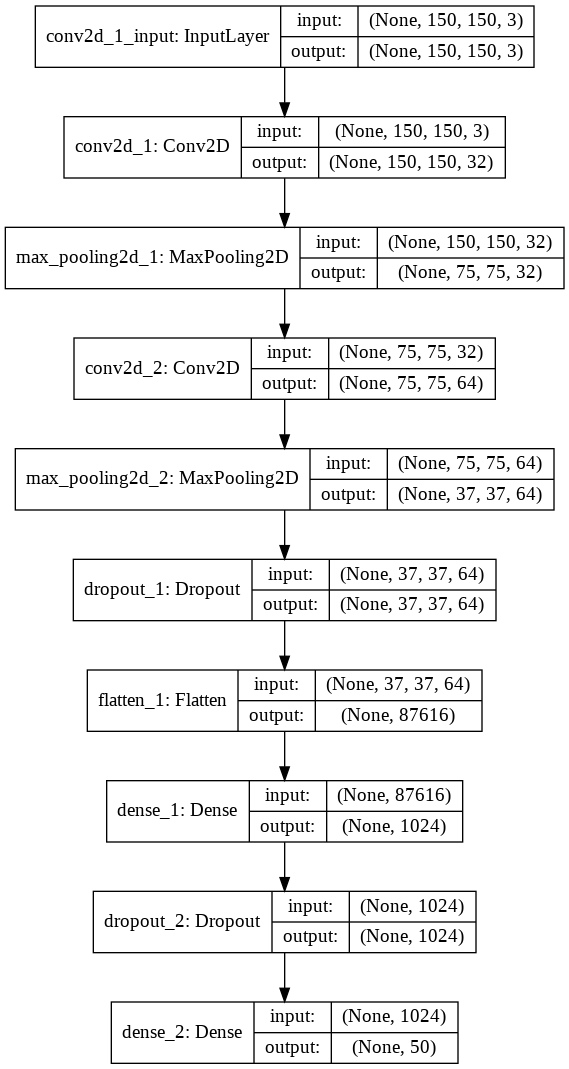

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model,
           to_file='landmark_recognition5.png',
           show_shapes=True,
           show_layer_names=True)

In [0]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

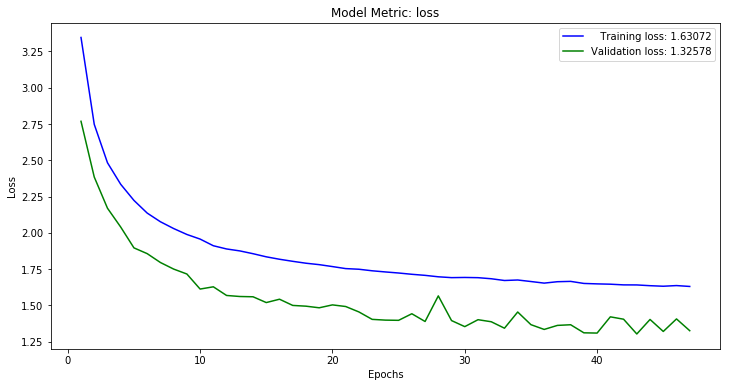

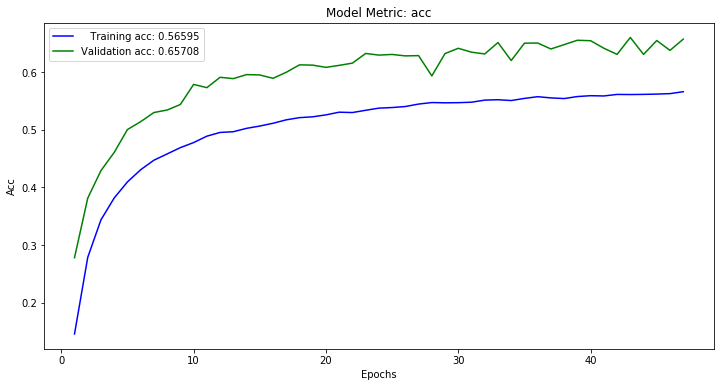

In [0]:
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
plot_keras_history(model6)